### Basic Holography

This example shows how to:

1. Make and visualize a target far-field pattern (a spot array)
2. Solve for the associated near-field phase mask using GPU accelerated GS algorithms 
3. Monitor GS algorithm convergence
4. Perform GS optimization with more general targets

In [1]:
# Header
# basic ipython configuration 
# (reload source code automatically and plots inline)
%load_ext autoreload
%autoreload 2
%matplotlib inline
%load_ext snakeviz
%load_ext line_profiler

import os, sys
import numpy as np
import matplotlib.pyplot as plt
try:
    import cupy as cp
except:
    cp = np
import cv2

# Add slmsuite to the python path. TODO: Remove and replace with package import
sys.path.append(os.path.join(os.getcwd(), '../..'))
# Import GS algorithms
# from slmsuite.holography.algorithms import FastGS
# Import spot array class for target generation
# from slmsuite.holography.SpotArray import SpotArray
from slmsuite.holography.algorithms import Hologram
import slmsuite.holography.lcos_toolbox as lcos_toolbox

In [53]:
holograms = {}

# Hologram creation and optimization
def test():
    # Now lets try something other than spots, like a picture:
    path = os.path.join(os.getcwd(), '../static/qp-slm-small.png')
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

    # This logo has white background, so we invert such that the field is dark.
    img = cv2.bitwise_not(img)

    # Resize (zero pad) for GS.
    shape = (1024,1024)
    target = lcos_toolbox.pad(img, shape)

    for method in ["GS", "WGS-Kim"]:
        holograms[method] = Hologram(target)
        holograms[method].optimize(method=method, maxiter=200, stat_groups=['computational'])

%snakeviz test()

100%|██████████| 200/200 [00:01<00:00, 135.99it/s]


 
*** Profile stats marshalled to file 'C:\\Users\\EXPERI~1\\AppData\\Local\\Temp\\tmpexi3e6sq'.
Embedding SnakeViz in this document...


In [47]:
%lprun -f Hologram.GS test()

100%|██████████| 200/200 [00:00<00:00, 329.24it/s]


Timer unit: 1e-07 s

Total time: 1.059 s
File: c:\Users\Experiment\Documents\GitHub\qp-slm\docs\examples\../..\slmsuite\holography\algorithms.py
Function: GS at line 423

Line #      Hits         Time  Per Hit   % Time  Line Contents
   423                                               def GS(self, iterations, callback):
   424                                                   """
   425                                                   GPU-accelerated Gerchberg-Saxton (GS) iterative Fourier transform algorithm.
   426                                           
   427                                                   Solves the "phase problem": approximates the near-field phase that
   428                                                   transforms a known near-field source amplitude to a known near-field
   429                                                   target amplitude.
   430                                           
   431                                                   

In [32]:
%lprun -f Hologram._update_weights_generic test()

100%|██████████| 200/200 [00:02<00:00, 80.20it/s]


Timer unit: 1e-07 s

Total time: 0.894737 s
File: c:\Users\Experiment\Documents\GitHub\qp-slm\docs\examples\../..\slmsuite\holography\algorithms.py
Function: _update_weights_generic at line 572

Line #      Hits         Time  Per Hit   % Time  Line Contents
   572                                               @staticmethod
   573                                               def _update_weights_generic(weight_amp, feedback_amp, target_amp=None, method=None):
   574                                                   """
   575                                                   Helper function to process weight feedback according to the chosen weighting method.
   576                                           
   577                                                   Note
   578                                                   ~~~~~~~~
   579                                                   ``weight_amp`` *is* modified in-place and ``feedback_amp`` *may be* modified in-place.
   580      

In [43]:
%lprun -f Hologram._update_weights_generic test()

100%|██████████| 200/200 [00:01<00:00, 107.91it/s]


Timer unit: 1e-07 s

Total time: 0.162267 s
File: c:\Users\Experiment\Documents\GitHub\qp-slm\docs\examples\../..\slmsuite\holography\algorithms.py
Function: _update_weights_generic at line 572

Line #      Hits         Time  Per Hit   % Time  Line Contents
   572                                               @staticmethod
   573                                               def _update_weights_generic(weight_amp, feedback_amp, target_amp=None, method=None):
   574                                                   """
   575                                                   Helper function to process weight feedback according to the chosen weighting method.
   576                                           
   577                                                   Caution
   578                                                   ~~~~~~~~
   579                                                   ``weight_amp`` *is* modified in-place and ``feedback_amp`` *may be* modified in-place.
   580   

In [14]:
h = holograms['GS']

def test():
    for xx in range(100):
        h.update_stats(['computational'])

%lprun -f Hologram._calculate_stats test()

Timer unit: 1e-07 s

Total time: 0.56279 s
File: c:\Users\Experiment\Documents\GitHub\qp-slm\docs\examples\../..\slmsuite\holography\algorithms.py
Function: _calculate_stats at line 659

Line #      Hits         Time  Per Hit   % Time  Line Contents
   659                                               @staticmethod
   660                                               def _calculate_stats(feedback_amp, target_amp, mp=cp, efficiency_compensation=True):
   661                                                   """
   662                                                   Helper function to analyze how close the feedback is to the target.
   663                                           
   664                                                   feedback_amp : numpy.ndarray OR cupy.ndarray
   665                                                       Computational or measured result of holography.
   666                                                   target_amp : numpy.ndarray OR cupy.ndarra

In [44]:
h = holograms['GS']

def test2():
    for xx in range(1000):
        h.update_stats(['computational'])

%lprun -f Hologram._calculate_stats test2()

Timer unit: 1e-07 s

Total time: 4.10394 s
File: c:\Users\Experiment\Documents\GitHub\qp-slm\docs\examples\../..\slmsuite\holography\algorithms.py
Function: _calculate_stats at line 673

Line #      Hits         Time  Per Hit   % Time  Line Contents
   673                                               @staticmethod
   674                                               def _calculate_stats(feedback_amp, target_amp, mp=cp, efficiency_compensation=True):
   675                                                   """
   676                                                   Helper function to analyze how close the feedback is to the target.
   677                                           
   678                                                   feedback_amp : numpy.ndarray OR cupy.ndarray
   679                                                       Computational or measured result of holography.
   680                                                   target_amp : numpy.ndarray OR cupy.ndarra

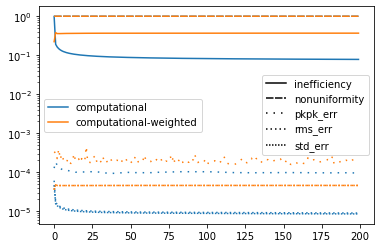

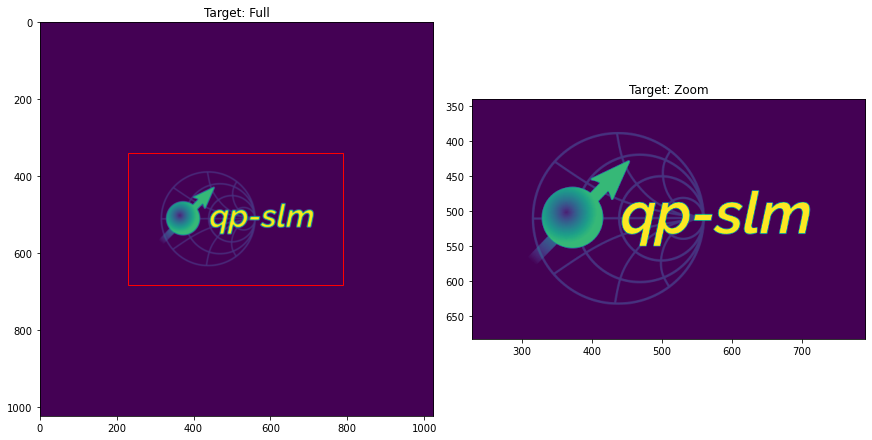

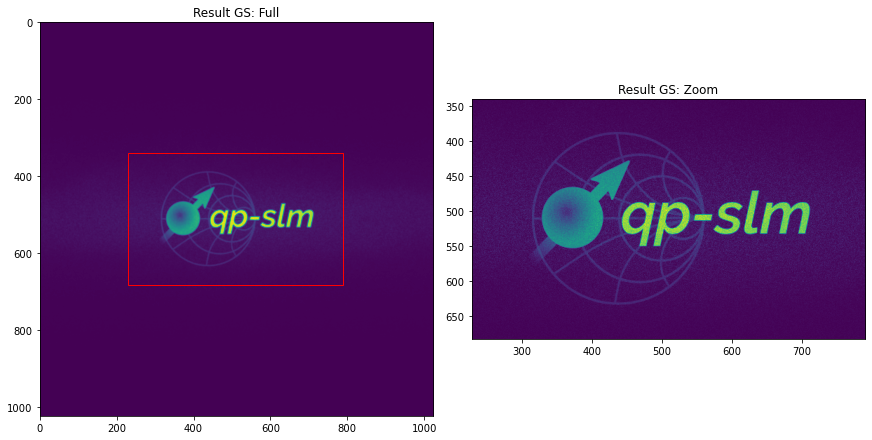

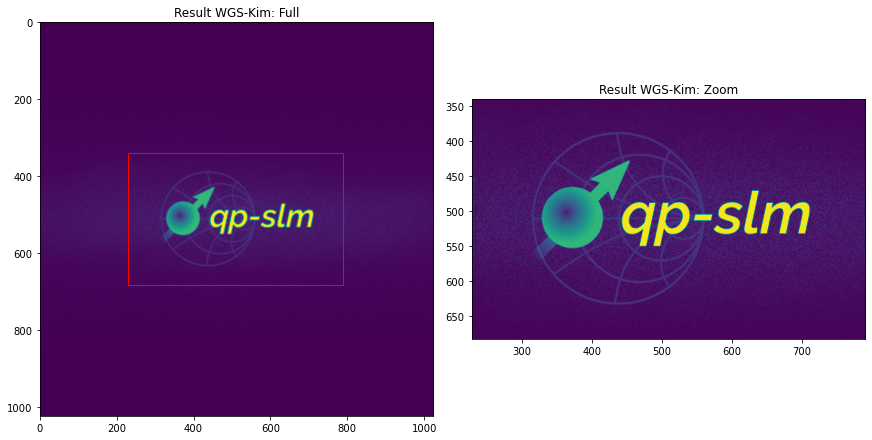

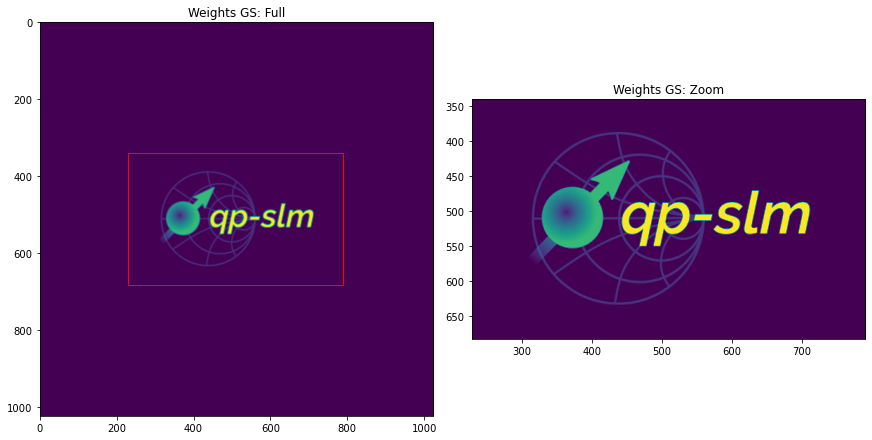

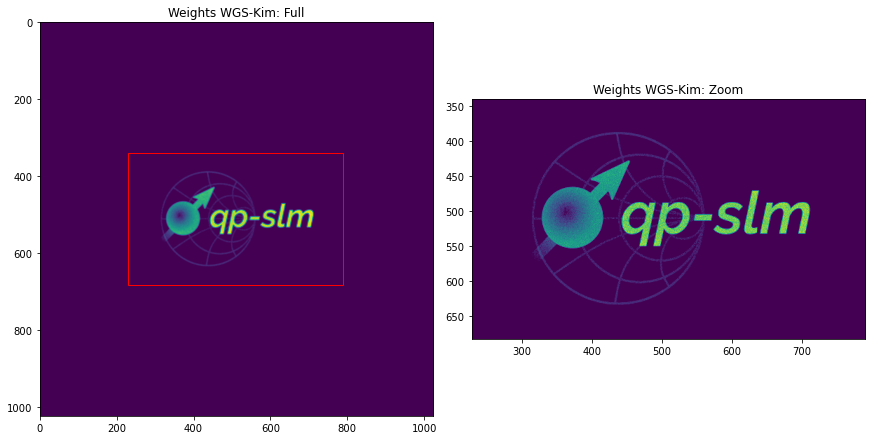

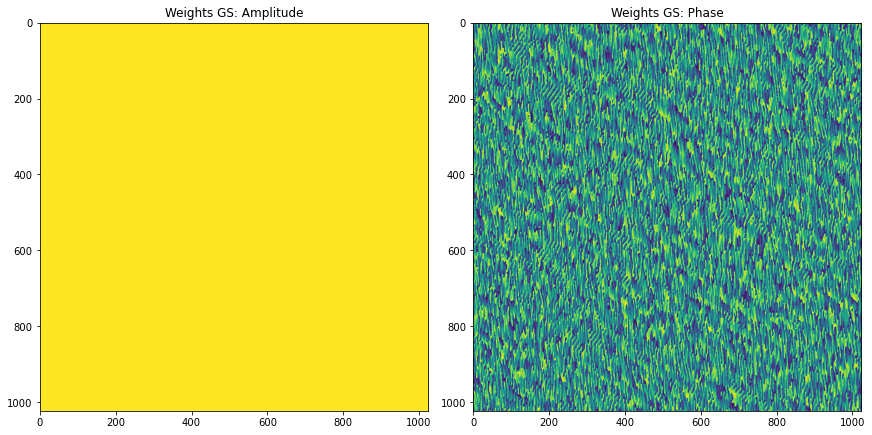

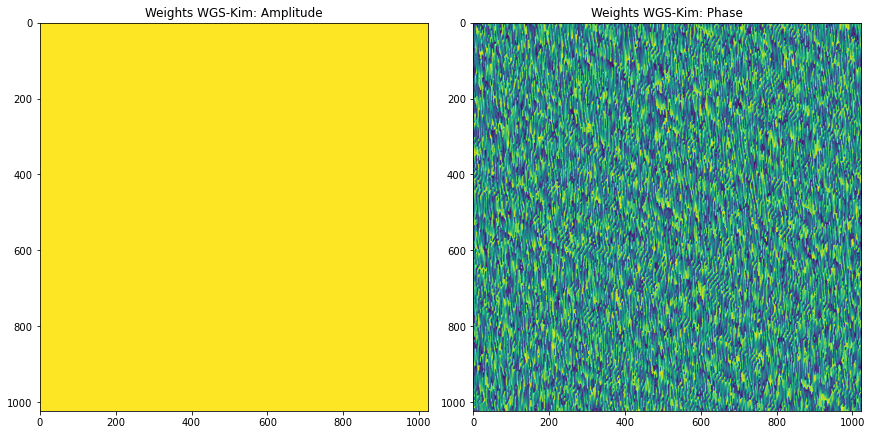

In [54]:
# Plotting
# Stats
statscombined = holograms["GS"].stats
statscombined["stats"]["computational-weighted"] = \
    holograms["WGS-Kim"].stats["stats"]["computational"]

holograms["GS"].plot_stats(statscombined)

# Farfield plots
limits = holograms["GS"].plot_farfield()

# Comparisons
for method in ["GS", "WGS-Kim"]:
    holograms[method].plot_farfield(source=holograms[method].amp_ff, 
        limits=limits, title='Result ' + method)

for method in ["GS", "WGS-Kim"]:
    holograms[method].plot_farfield(source=holograms[method].weights, 
        limits=limits, title='Weights ' + method)

for method in ["GS", "WGS-Kim"]:
    holograms[method].plot_nearfield(title='Weights ' + method)

In [56]:
from slmsuite.holography.algorithms import SpotHologram

[[ nan  nan]
 [ nan  nan]
 [512. 512.]]


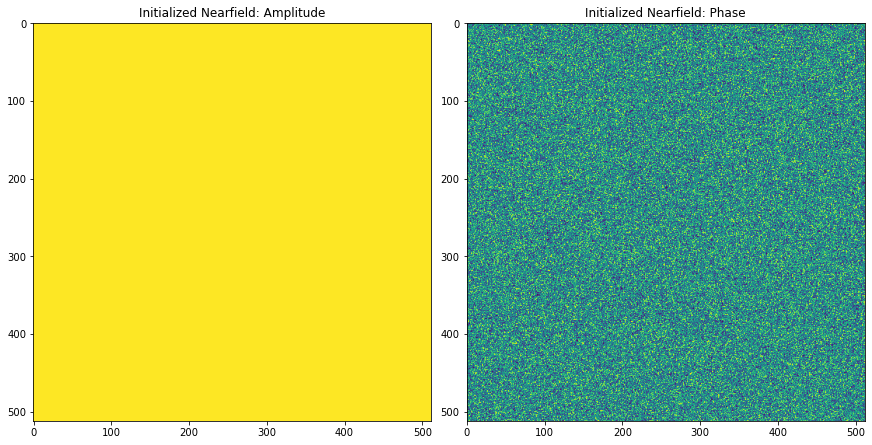

100%|██████████| 100/100 [00:01<00:00, 77.17it/s]


In [116]:
# Setup a basic spot array
shape = (1024, 1024)
array_hologram = SpotHologram.make_rectangular_array(shape,
    array_shape=(20,10), array_pitch=(5,10), basis='knm', slm_shape=(512,512))

array_hologram.plot_nearfield(title='Initialized Nearfield')

array_hologram.optimize(method="WGS-Kim", maxiter=100, stat_groups=['computational', 'computational_spot'])

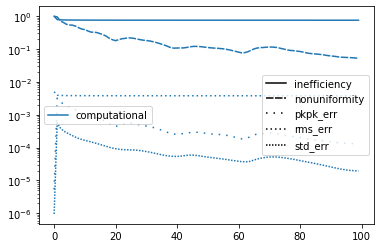

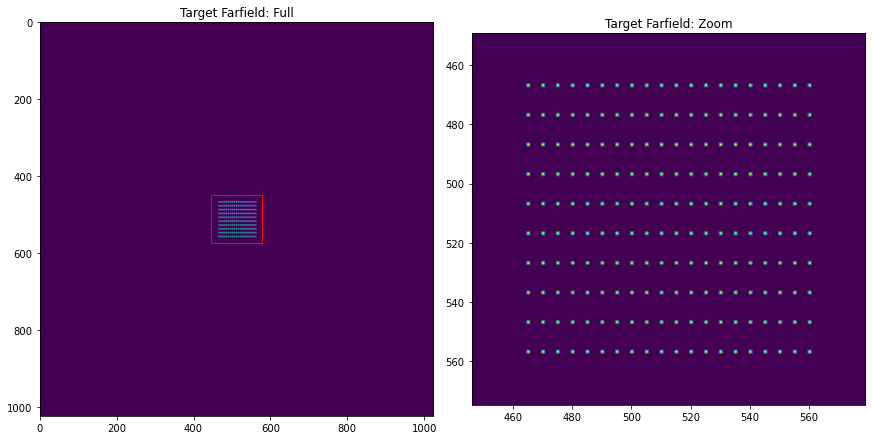

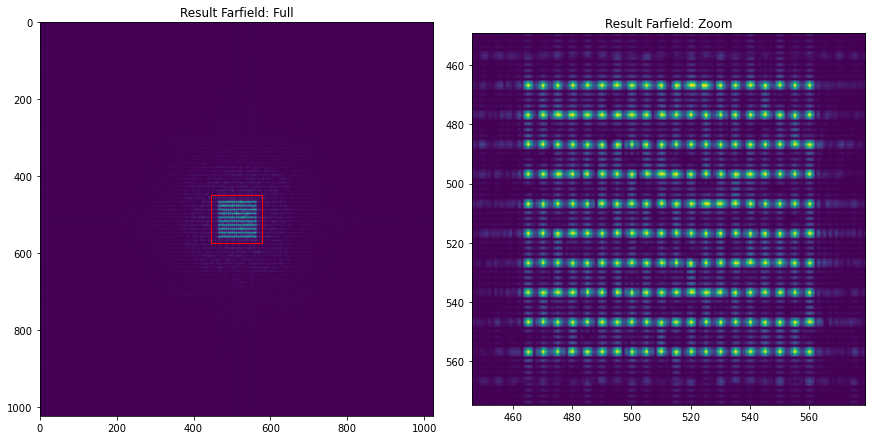

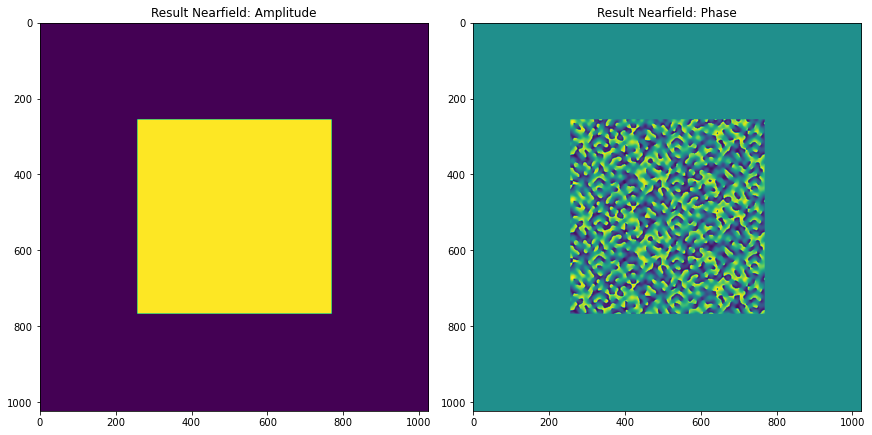

In [117]:
# Spot array plots and stats
array_hologram.plot_stats()

limits = array_hologram.plot_farfield(title='Target Farfield')
array_hologram.plot_farfield(source=array_hologram.amp_ff, 
    limits=limits, title='Result Farfield')

array_hologram.plot_nearfield(title='Result Nearfield', padded=True)